In [34]:
import pandas as pd

In [35]:
#### processing each book

## for 0:

def process_zero(df):
    df = df.copy()
    df = df[['handicap', 'odds', 'name']]
    df[['participant_name', 'name']] = df['name'].str.rsplit(' ', 1, expand=True)

    df = df.dropna()
    return df

## for 1: (Pinnacle)

def process_one(df):
    df = df.copy()
    df.dropna()
    return df[['handicap', 'odds', 'participant_name', 'name']]

## for two and six (DraftKings)

def process_two_six(df):
    df = df.copy()
    df = df[['handicap', 'odds', 'name']]

    df[['name', 'participant_name']] = df['name'].str.split(' - ', expand=True)
    df['participant_name'] = df['participant_name'].str.strip()

    df.dropna()

    return df

## for three and five

def process_three_five(df):
    df = df.copy()
    df = df[['handicap', 'odds', 'name', 'description']]

    df[['participant_name', 'description', 'a']] = df['description'].str.rsplit(' ', n=2, expand=True)
    df['participant_name'] = df['participant_name'].str.strip()

    df = df.drop(columns=['description', 'a'])
    df = df.dropna()

    return df


## for seven and eight

def process_seven_eight(df):
    df = df.copy()
    df = df[['handicap', 'odds', 'name']]

    df[['participant_name', 'name', 'a']] = df['name'].str.rsplit(' ', n=2, expand=True)

    df = df.drop(columns=['a'])
    df = df.dropna()

    return df

def process_master(data):
    df = pd.DataFrame.from_dict(data['market']['outcomes'])
    df = df[~df['description'].str.contains("ALT", case=False)]

    
    if data['bookie_key'] == "pinnacle":
        df = df.copy()
        df.dropna()
        df = df[['handicap', 'odds', 'participant_name', 'name']]
        return df
    # elif data['bookie_key'] == "fanduel":
    #     df = df.copy()
    #     df = df[['handicap', 'odds', 'name']]
    #     print(df)
    #     df[['participant_name', 'name']] = df['name'].str.rsplit(' ', 1, expand=True)

    #     df = df.dropna()
    #     return df
    elif data['bookie_key'] == "draftkings":
        df = df.copy()
        df = df[['handicap', 'odds', 'name']]

        df[['name', 'participant_name']] = df['name'].str.split(' - ', expand=True)
        df['participant_name'] = df['participant_name'].str.strip()

        df.dropna()
    
        return df
    elif data['bookie_key'] == "betrivers":
        df = df.copy()
        df = df[['handicap', 'odds', 'name']]

        df[['name', 'participant_name']] = df['name'].str.split(' - ', expand=True)
        df['participant_name'] = df['participant_name'].str.strip()

        df.dropna()

        return df

In [36]:
#### for merging all the books

## agg
def agg(df):    
    result_df = df.groupby(['participant_name', 'name']).agg({'handicap': 'first', 'odds': 'median'}).reset_index()
    return result_df

## pivot
def pivot(df):
    df = df.copy()
    pivot_df = pd.pivot_table(df, values='odds', index=['handicap', 'participant_name'], columns='name').reset_index()
    pivot_df.columns = ['line', 'participant_name', 'over_odds', 'under_odds']

    return pivot_df

## calculate odds
## adapted from Ammar Sulmanjee

def calculate_odds(x, y):
    if x >= 0:
        decimal_odds_1 = 1 + x/100
    else: 
        decimal_odds_1 = 1 + 100/abs(x)
        
    if y >= 0:
        decimal_odds_2 = 1 + y/100
    else: 
        decimal_odds_2 = 1 + 100/abs(y)

    imp_prob1 = (1 / decimal_odds_1) * 100
    imp_prob2 = (1 / decimal_odds_2) * 100

    total_implied_prob = round(imp_prob1 + imp_prob2, 4)
    fair_prob1 = round(imp_prob1 / total_implied_prob * 100, 2)
    fair_prob2 = round(imp_prob2 / total_implied_prob * 100, 2)

    index = "over" if fair_prob1 > fair_prob2 else "under"

    return {"type": index, "ev": max(fair_prob1, fair_prob2) - 50}

In [37]:
bets = pd.DataFrame(columns = ['participant_name', 'ev', 'market', 'line'])

In [38]:
import os
import json

startdate = '2023-10-24'
enddate = '2024-01-26'

for d in pd.date_range(startdate, enddate):
    date = d.strftime("%Y-%m-%d")

    fantasy_directory = 'NBA_DATA/other/' + date
    bookies_directory = 'NBA_DATA/books/' + date
    
    if not os.path.exists(fantasy_directory):
        continue
    for market in os.listdir(fantasy_directory):
        if not os.path.exists(os.path.join(fantasy_directory, market)):
            continue
        for game in os.listdir(os.path.join(fantasy_directory, market)):
            #load the json file
            with open(os.path.join(fantasy_directory, market, game)) as f:
                data = json.load(f)
                # iterate over the data's "fantasy_books" subfield
                ud = None
                if 'fantasy_books' not in data:
                    continue
                for book in data['fantasy_books']:
                    if book['bookie_key'] == "prizepicks":
                        ud = pd.DataFrame.from_dict(book['market']['lines'])
                        ud = ud[['participant_name', 'line']]
                        ud.columns = [ud.columns[0], 'handicap']
                        

                        # get sportsbook odds
                        with open(os.path.join(bookies_directory, market, game.replace("fantasy", "books"))) as f:
                            bookies_data = json.load(f)
                            books = []
                            for bookie in bookies_data['sportsbooks']:
                                if bookie['bookie_key'] == "pinnacle" or bookie['bookie_key'] == "betrivers" or bookie['bookie_key'] == "draftkings":
                                    df = process_master(bookie)
                                    books.append(df)
                
                            # we need to concat the books

                            new_datasets = []
                            for dataset in books:
                                dataset = pd.merge(dataset, ud, how='inner', on = ['participant_name', 'handicap'])

                                if dataset.shape[0] > 0 and dataset.shape[1] > 0:
                                    dataset = pivot(dataset)
                                    dataset = dataset[abs(dataset['over_odds']) < 250]
                                    dataset = dataset[abs(dataset['under_odds']) < 250]
                                    
                                    if dataset.shape[0] > 0 and dataset.shape[1] > 0:
                                        new_datasets.append(dataset)
                            if new_datasets == []:
                                continue
                            concat = pd.concat(new_datasets, axis=0)
                            final = concat.copy()

                            # drop rows with null values

                            # drop rows with null values
                            final = final.dropna()

                            
                            final[['type', 'ev']] = final.apply(lambda row: pd.Series(calculate_odds(row['over_odds'], row['under_odds'])), axis=1)
                            final = final.groupby(['participant_name', 'line', 'type']).agg({'ev': 'median', 'over_odds':'median', 'under_odds':'median'}).reset_index()
                            # final['ev'] = final['ev'] - 2.06

                            final = final[final['ev'] >= 4.99] # Minimum 5% edge

                            final['market'] = market
                            final['game'] = game
                            final['date'] = date

                            if final.shape[0] > 0: bets = pd.concat([bets, final[['participant_name', 'ev', 'type', 'market', 'line', 'game', 'date', 'over_odds', 'under_odds']]])

bets = bets.sort_values(by=['date', 'ev'], ascending=False)
bets.dropna(inplace=True)
bets.drop_duplicates(keep='first', inplace=True, ignore_index=True)

# delete file named Prizepicks_NBA_DATA_bets.csv if it exists
if os.path.exists('Prizepicks_NBA_DATA_bets.csv'):
    os.remove('Prizepicks_NBA_DATA_bets.csv')

bets.to_csv('Prizepicks_NBA_DATA_bets.csv', index=False)

/var/folders/l2/3rlb181n59v6czltkxgq_02m0000gn/T/ipykernel_22715/1229914005.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  if final.shape[0] > 0: bets = pd.concat([bets, final[['participant_name', 'ev', 'type', 'market', 'line', 'game', 'date', 'over_odds', 'under_odds']]])


In [39]:
bets = pd.read_csv('Prizepicks_NBA_DATA_bets.csv')

In [40]:
bets.shape

(6248, 9)

count     90.000000
mean      69.422222
std       36.953958
min       12.000000
25%       45.000000
50%       65.000000
75%       90.000000
max      242.000000
dtype: float64


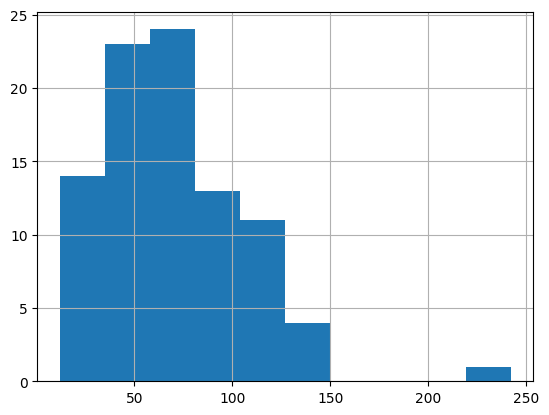

In [41]:
# Now, we will analyze the bets

# Count the number of bets per day
bets_per_day = bets.groupby('date').size()

# Show the five number summary of the number of bets per day
print(bets_per_day.describe())

# Show the distribution of bets per day in a line plot where the x-axis is the number of bets and the y-axis is the number of days with those many bets
import matplotlib.pyplot as plt
bets_per_day.hist()
plt.show()

date
2023-10-24    8.5625
2023-10-25    7.2250
2023-10-26    6.5150
2023-10-27    7.5200
2023-10-28    7.5200
               ...  
2024-01-22    8.4850
2024-01-23    7.3750
2024-01-24    6.6500
2024-01-25    7.5200
2024-01-26    7.8525
Name: ev, Length: 90, dtype: float64
count    90.000000
mean      8.044167
std       2.426281
min       6.330000
25%       7.089375
50%       7.520000
75%       7.959375
max      23.485000
Name: ev, dtype: float64


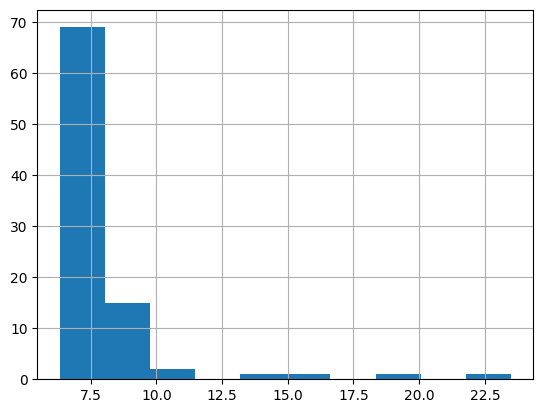

[ 7.535991908233608 ,  8.552341425099723 ]


In [42]:
median_ev_per_day = bets.groupby('date')['ev'].median()
print(median_ev_per_day)

# Show the five number summary of the median EV per day
print(median_ev_per_day.describe())

# Show the distribution of median EV per day in a line plot where the x-axis is the median EV and the y-axis is the number of days with that median EV
import matplotlib.pyplot as plt
median_ev_per_day.hist()
plt.show()

# Show me the 95% confidence interval of the median EV per day
# get 95% confidence interval
from scipy import stats
import numpy as np
confidence = 0.95
data = median_ev_per_day
n = len(data)
m = np.mean(data)
std_err = stats.sem(data)
h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
print("[", m-h, ", ", m+h, "]")

market
player_rebounds_over_under                   1271
player_points_over_under                      762
player_assists_over_under                     761
player_assists_rebounds_over_under            733
player_threes_over_under                      669
player_blocks_steals_over_under               593
player_assists_points_rebounds_over_under     391
player_assists_points_over_under              357
player_points_rebounds_over_under             281
player_steals_over_under                      262
player_blocks_over_under                      168
Name: count, dtype: int64


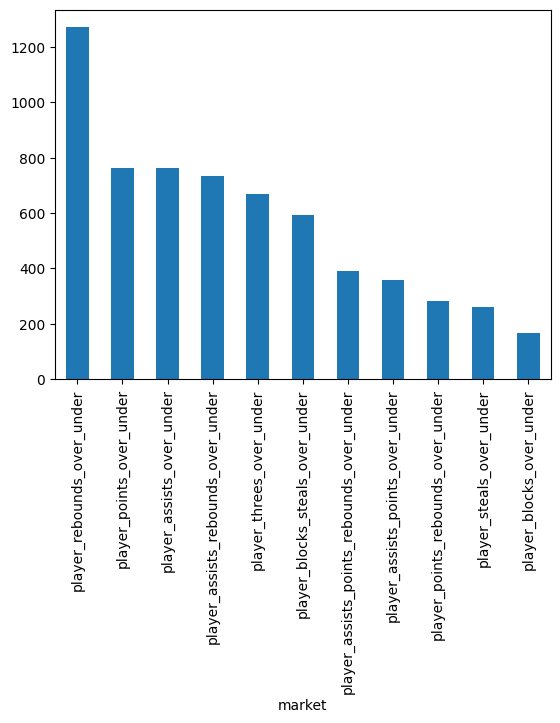

In [43]:
bets_per_market = bets['market'].value_counts()
print(bets_per_market)

# Graph the bets per market in a bar chart
import matplotlib.pyplot as plt
bets_per_market.plot.bar()
plt.show()

In [44]:
# We will find the number of potentially fake bets
# We say that a bet is fake if the edge over the house is greater than 10%
fake_bets = bets[bets['ev'] >= 10]
print(fake_bets)

real_bets = bets[bets['ev'] < 10]
print(real_bets)

# Show the size differences between the real and fake bets
print(fake_bets.shape)
print(real_bets.shape)

       participant_name     ev                           market  line   type  \
0           Buddy Hield  16.13         player_threes_over_under   3.5  under   
1          Franz Wagner  16.00         player_threes_over_under   1.5   over   
2         Kawhi Leonard  16.00  player_blocks_steals_over_under   2.5   over   
3        Jordan Hawkins  16.00       player_rebounds_over_under   2.5  under   
4     Jonas Valanciunas  15.30  player_blocks_steals_over_under   1.5  under   
...                 ...    ...                              ...   ...    ...   
6155    Zion Williamson  10.17       player_rebounds_over_under   6.5   over   
6232   D'Angelo Russell  14.13         player_threes_over_under   2.5  under   
6233       Jusuf Nurkic  11.13        player_assists_over_under   2.5   over   
6234       Devin Booker  10.91        player_assists_over_under   6.5  under   
6235       Jamal Murray  10.17         player_threes_over_under   2.5  under   

                                       